# A Brief and Non-Expert Introduction to Tigramite
[Ke Li](keli95566@gmail.com)
May 4th, 2021
The German Areospace Center, Institute of Data Science

## 1-Background: Causal Inference (CI) and Causal Discovery

Venn Diagram of Data Science (Source: [Talk by Dr.Marlene Kretschmer at the University of Reading](https://www.youtube.com/watch?v=CRrDqhA27gY))


<img src="./images/02_presentation/Marlene_overview.png" alt="drawing" width="650"/>

- Causal Inference: Given domain expert data or casual relationship to conduct statistical evaluation (e.g. regression) of the causual relationship.
- Causal Discovery: Predict causal relationship from unstructured and observational data. (a sub domain of casual inference)


## 2- Background: General Step of Causal Inference

(Source: [Talk by Dr.Marlene Kretschmer at the University of Reading](https://www.youtube.com/watch?v=CRrDqhA27gY))


<img src="./images/02_presentation/Marlene_step_of_ci.png" alt="drawing" width="650"/>

* Challenge: In area such as climate science, it is not possible to provide physical conditioned to test independecy and causality such as in Step3


## 3- Background: Constraint-Based Causal Discovery 

Constraint causal graph by using results of conditional independence tests in observational data. 
(Make constraint in determining causality graph )

(Source: [Talk by Jakob "Causal inference in Earth system sciences"](https://www.youtube.com/watch?v=wJ_AkNELm6Q))

<img src="./images/02_presentation/jakob_causal_discovery.png" alt="drawing" width="650"/>



Example: If we do a statistical conditional independence test on unstructured observational data on parameter X1, X2, X3 with the following results:

* X1 and X2 are dependent
* X2 and X3 are dependent
* X1 and X3 are dependent
* X1 and X3 are indepedent given X2

It will give different possible solutions (is it a fork or a chain? we can not say for sure)

<b>Causal Discovery with time series data gives extra constrain => Time only goes forward => Free feature that makes causal discovery easier!</b>


## 4- Introduction to Tigramite: Time Series Graph


Time series graph visualizes the causality graph of different observational data ($X_1$, $X_2$, $X_3$) at different time lag $t, t-1, t-2$, where $t<\tau_{max}$.

(Source: [Talk by Jakob "Causal inference in Earth system sciences"](https://www.youtube.com/watch?v=wJ_AkNELm6Q))

<img src="./images/02_presentation/time_series_jakob.png" alt="drawing" width="650"/>

<b>But, result in the following disadvantages:</b>
* High dimensionality problem
* Auto-correlation makes statistical test harder.

Which  the PCMIC+(2020) and the Latent PCMIC (2020) algorithm in tigramite can address. 

## 5- Tigramite Explained: A Dummy Example of Time Series Graph in Tigramite with Covid-19 Data


In [ ]:
# Let's take data from random city, for example Madrid
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline    

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

### Covid Data of Madrid Taken from Google API

In [3]:
epi = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv")
madrid = epi[epi.key == 'ES_MD']
madrid.tail()

# Here is what the data looks like

,date,key,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
6190805,2021-04-25,ES_MD,474.0,12.0,NaN,NaN,674447.0,15000.0,NaN,NaN
6206238,2021-04-26,ES_MD,2093.0,14.0,NaN,NaN,676540.0,15014.0,NaN,NaN
6221816,2021-04-27,ES_MD,2346.0,10.0,NaN,NaN,678886.0,15024.0,NaN,NaN
6237414,2021-04-28,ES_MD,1753.0,0.0,NaN,NaN,680639.0,15024.0,NaN,NaN
6252006,2021-04-29,ES_MD,0.0,0.0,NaN,NaN,680639.0,15024.0,NaN,NaN


### How the Time Series Data Look Like from Tigramite Dataframe

$T_c$: Total confirmed
$c$: Daily New confirmed
$d$: Daily New Deceased
$T_d$: Total Deceased

In [4]:
# We convert the csv data to numpy array
madrid_np = madrid.values # convert panda dataframe to numpy array
raw_data = np.empty((485,4))
raw_data[:,0] = madrid_np[:,2]
raw_data[:,1] = madrid_np[:,3]
raw_data[:,2] = madrid_np[:,6]
raw_data[:,3] = madrid_np[:,7]

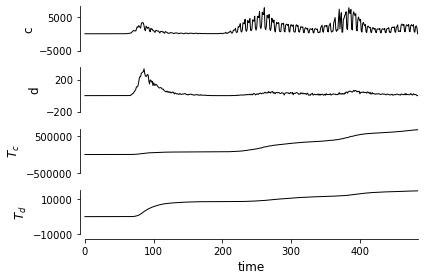

In [6]:
# var_names = ["new_confirmed", "new_deceased","total_confirmed","total_deceased"]
var_names = ["c", "d",r'$T_c$',r'$T_d$']
# Create Tigramite dataframe
dataframe = pp.DataFrame(raw_data, datatime = np.arange(len(raw_data)), var_names=var_names)
# Visualize time series data
tp.plot_timeseries(dataframe); plt.show()

In [9]:
# Initialize partial correlation test object for conditional independency test
parcorr = ParCorr(significance='analytic')
# Initialize PCMCI framework
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)

### Correlation tests : show how each variables are correlated

pcmci.get_lagged_dependencies() : Unconditional lagged independence tests.



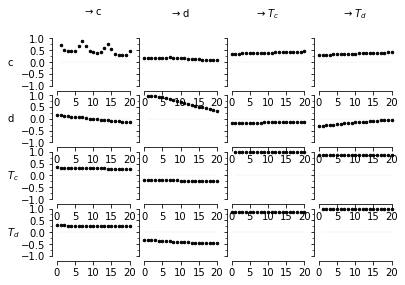

In [19]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

### Run Conditional Independence Test

In [20]:
pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=4, pc_alpha=None) # run conditional independence test
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
#pcmci.print_significant_links(
#        p_matrix = results['p_matrix'], 
#        q_matrix = q_matrix,
#        val_matrix = results['val_matrix'],
#        alpha_level = 0.01)

### Plot Causal Graph7

MCI: confidence score with $[-1,1]$, -1 means negatively causal relationship, with 1 positive causal relationship. The absolute value indicate the strength of the causal relationship

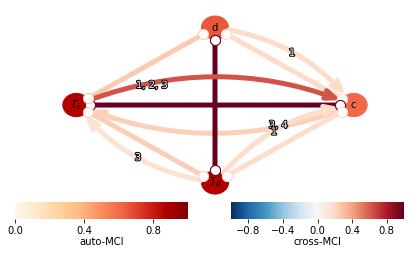

In [25]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

### Plot Time Series Graph


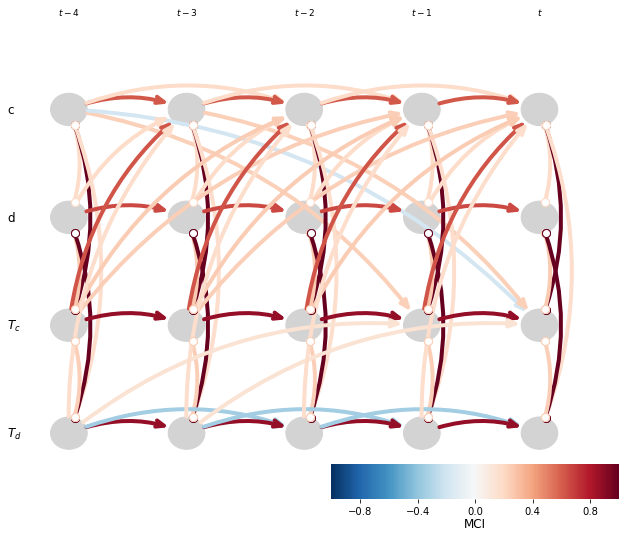

In [23]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(10, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

### Make Prediction Based on the Time Series Graph

### Summary

This is of course, a non-expert example of how to use tigramite.
Tigramite is designed to study observational climate data, and to build a better prediction model on covid data, we need to make better assumptions of the data, and more post processing of the data.

As we can see, the time lag interval is only one day, which gives a lot of unconfident causal link in the time sereis graph.


## 6- Weak Points of Current Time Series Graph Visualization from the Example

* Visualization breakdown with long time lag. => This is due to the high dimensionality problem of time series causality analysis. 
* Color scheme breakdown when there exits a lot of causal links between different edges.
* No interactivity of time series graph (The visualization is implemented with matplotlib pyplot, can we improve the interactivity by using javascript?)
* More challenges (see figure below) to come that requires more interactivity and better design of the visualization of time series graph.

<img src="./images/02_presentation/remaining_challenges_jakob.png" alt="drawing" width="750"/>

(Source: [Talk by Jakob "Causal inference in Earth system sciences"](https://www.youtube.com/watch?v=wJ_AkNELm6Q))




## 7- Next Step: User Study

* Send out user survey
* Conduct user interview
